In [1]:
import os, sys, time

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable, Function

import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import pylab
import matplotlib.pyplot as plt

from scipy.misc import imread, imresize

from invert import invert

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import loadseg
import expdir
import intersect
import upsample
from labelprobe import cached_memmap

In [3]:
gpu = 1

cuda = True if gpu is not None else False
use_mult_gpu = isinstance(gpu, list)
if cuda:
    if use_mult_gpu:
        os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu).strip('[').strip(']')
    else:
        os.environ['CUDA_VISIBLE_DEVICES'] = '%d' % gpu
print(torch.cuda.device_count(), use_mult_gpu, cuda)

(1L, False, True)


In [5]:
directory='/home/ruthfong/NetDissect/probes/pytorch_alexnet_imagenet'
if not os.path.exists(directory):
    directory='/scratch/local/ssd/ruthfong/NetDissect/probes/pytorch_alexnet_imagenet'
    assert(os.path.exists(directory))
blob='features.7'

In [6]:
ed = expdir.ExperimentDirectory(directory)

In [7]:
info = ed.load_info()
blob_info = ed.load_info(blob=blob)
shape = blob_info.shape
ds = loadseg.SegmentationData(info.dataset)
categories = ds.category_names()

In [8]:
K = shape[1]
L = ds.label_size()
N = ds.size()

In [9]:
quantile = 0.005
qcode = ('%f' % quantile).replace('0.','').rstrip('0')
quantdata = ed.open_mmap(blob=blob, part='quant-*', shape=(K, -1))
threshold = quantdata[:, int(round(quantdata.shape[1] * quantile))]
thresh = threshold[:, np.newaxis, np.newaxis]

In [10]:
fnread = ed.mmap_filename(blob=blob)
blobdata = cached_memmap(fnread, mode='r', dtype='float32', shape=shape)

In [11]:
#from labelprobe import onehot, primary_categories_per_index, cached_memmap

In [12]:
from indexdata import load_image_to_label

In [13]:
image_to_label = load_image_to_label(directory)

In [14]:
linear_ind_ious = ed.open_mmap(blob=blob, part='linear_ind_ious', mode='r', dtype='float32', shape=(L,N))
single_ind_ious = ed.open_mmap(blob=blob, part='single_ind_ious', mode='r', dtype='float32', shape=(L,N,K))
linear_set_ious = ed.open_mmap(blob=blob, part='linear_set_ious', mode='r', dtype='float32', shape=(L,))
single_set_ious = ed.open_mmap(blob=blob, part='single_set_ious', mode='r', dtype='float32', shape=(L,K))
weights = ed.open_mmap(blob=blob, part='linear_weights', mode='r', dtype='float32', shape=(L,K))

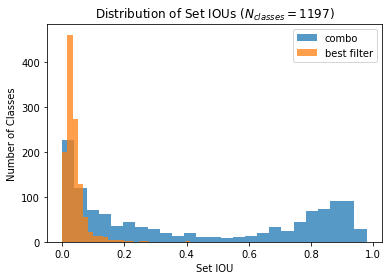

In [15]:
best_set_ious = np.max(single_set_ious[1:], axis=1)
f, ax = plt.subplots(1,1)
ax.hist(linear_set_ious[1:], alpha=0.75, bins=25, label='combo')
ax.hist(best_set_ious, alpha=0.75, bins=25, label='best filter')
ax.set_xlabel('Set IOU')
ax.set_ylabel('Number of Classes')
ax.set_title(r'Distribution of Set IOUs ($N_{classes}=%d$)' % (L-1))
ax.legend()
plt.show()

In [28]:
set_iou_rel = np.true_divide(linear_set_ious[1:], best_set_ious+1e-20)

In [29]:
np.sum(set_iou_rel > 1.)

945

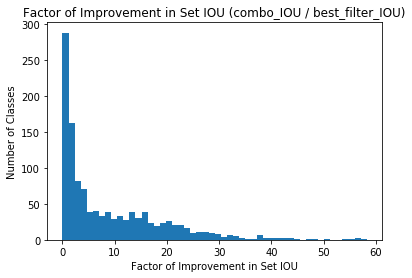

In [30]:
f, ax = plt.subplots(1,1)
ax.hist(set_iou_rel, bins=50)
ax.set_xlabel('Factor of Improvement in Set IOU')
ax.set_ylabel('Number of Classes')
ax.set_title('Factor of Improvement in Set IOU (combo_IOU / best_filter_IOU)')
#ax.legend()
plt.show()

In [31]:
iou_thresh = 0.04
print np.sum(best_set_ious > iou_thresh), np.sum(linear_set_ious[1:] > iou_thresh)

701 992


In [33]:
# similar to their metric, except doesn't eliminate duplicate concepts
print np.sum(np.max(single_set_ious, axis=0) > iou_thresh)

248


In [34]:
from viewprobe import NetworkProbe

In [35]:
net_probe = NetworkProbe(directory, blobs=[blob])

In [36]:
label_i = 19 # person
label_idx = np.where(image_to_label[:,label_i])[0]
best_filter = np.argmax(single_set_ious[label_i])
best_img = np.argmax(single_ind_ious[label_i,:,best_filter])

In [43]:
best_imgs_idx = np.argsort(linear_ind_ious[label_i,:])[::-1]
#best_imgs_idx = np.argsort(single_ind_ious[label_i,:,best_filter])[::-1]

In [44]:
from linearprobe_pytorch import CustomLayer

In [45]:
upsample = nn.Upsample(size=(113,113), mode='bilinear')

In [46]:
model = CustomLayer(K, upsample=True, up_size=(113, 113), act=True, positive=False)
model.weight.data[...] = torch.Tensor(weights[label_i])
if cuda:
    model.cuda()
model.eval()

CustomLayer (
  (upsample): Upsample(size=(113, 113), mode=bilinear)
  (activation): Sigmoid ()
)

In [47]:
input = torch.Tensor((blobdata[best_imgs_idx[:10]] > thresh).astype(float))
input_var = Variable(input.cuda() if cuda else input)
output_var = model(input_var)
soft_mask = output_var.data.cpu().numpy()
mask = (soft_mask > 0.5).astype(float)

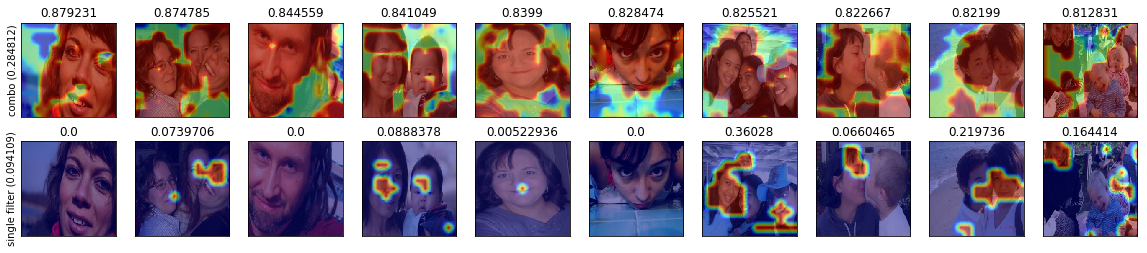

In [48]:
f, ax = plt.subplots(2,10,figsize=(20, 4))

ax[0][0].set_ylabel('combo (%f)' % linear_set_ious[label_i])
ax[1][0].set_ylabel('single filter (%f)' % single_set_ious[label_i][best_filter])
for i in range(10):
    img = imread(ds.filename(best_imgs_idx[i]))
    ax[0][i].imshow(img)
    ax[0][i].imshow(imresize(soft_mask[i], size=img.shape[:2], interp='bilinear', mode='F'), alpha=0.5, cmap='jet')
    ax[0][i].set_title(linear_ind_ious[label_i][best_imgs_idx[i]])
    ax[1][i].imshow(img)
    ax[1][i].imshow(imresize(upsample(input_var).data.cpu().numpy()[i][best_filter], size=img.shape[:2],
                         interp='bilinear', mode='F'), alpha=0.5, cmap='jet')
    ax[1][i].set_title(single_ind_ious[label_i,best_imgs_idx[i],best_filter])
for a in ax:
    for b in a:
        b.set_xticks([])
        b.set_yticks([])
plt.show()

In [74]:
label_names = np.array([ds.label[i]['name'] for i in range(L)])

In [50]:
from scipy.stats import pearsonr

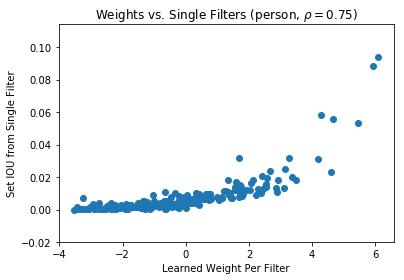

In [51]:
label_i = 19

f, ax = plt.subplots(1,1)

(rho, pv) = pearsonr(weights[label_i], single_set_ious[label_i])
ax.scatter(weights[label_i], single_set_ious[label_i])
ax.set_xlabel('Learned Weight Per Filter')
ax.set_ylabel('Set IOU from Single Filter')
ax.set_title(r'Weights vs. Single Filters (%s, $\rho=%.2f$)' % (label_names[label_i],rho))
plt.show()

In [83]:
from sklearn.decomposition import PCA

n_components = 10

pca = PCA(n_components = n_components)
pca_results = pca.fit_transform(weights)

print 'Explained variation per principal component: {}'.format(pca.explained_variance_ratio_)
print 'Total amount of variation explained by %d PCs = %f' % (n_components, np.sum(pca.explained_variance_ratio_))

Explained variation per principal component: [ 0.18603655  0.11984428  0.08604162  0.0664018   0.05166837  0.04448982
  0.03563145  0.03052211  0.02508439  0.02037435]
Total amount of variation explained by 10 PCs = 0.666095


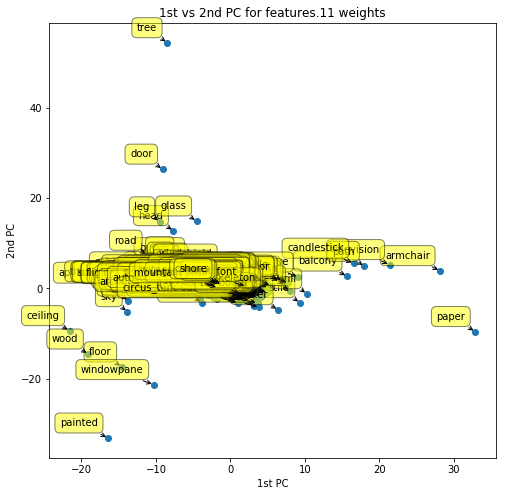

In [84]:
f, ax = plt.subplots(1,1, figsize=(8,8))

ax.scatter(
    pca_results[:,0], pca_results[:, 1], marker='o',
    cmap=plt.get_cmap('Spectral'))

for label, x, y in zip(label_names[12:], pca_results[:,0], pca_results[:,1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-10, 10),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

ax.set_xlabel('1st PC')
ax.set_ylabel('2nd PC')
ax.set_title('1st vs 2nd PC for %s weights' % blob)
plt.show()

In [76]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=50, algorithm='ball_tree').fit(weights)
distances, indices = nbrs.kneighbors(weights)

In [87]:
print distances[label_i]
print label_names[indices[label_i]]

[  0.          19.13498167  21.14582561  22.46674424  26.09505009
  26.33786052  26.42412738  26.70393955  26.75425487  26.77924781
  26.85279129  27.23098185  27.26541661  27.33190171  27.45930477
  27.47953436  27.78788845  27.81697067  27.8644456   27.97656163
  27.99086877  28.01018566  28.09915766  28.14638651  28.17897978
  28.23605066  28.28736741  28.3357784   28.35486771  28.37862997
  28.41620682  28.4196638   28.43912379  28.44170618  28.45148671
  28.48828485  28.4896138   28.4940786   28.53411431  28.53863475
  28.54338847  28.55464389  28.55565227  28.56598594  28.58622018
  28.61613917  28.61726845  28.6462227   28.66300905  28.67013997]
[u'person' u'torso' u'arm' u'leg' u'hair' u'horse' u'neck' u'cow' u'dog'
 u'bird' u'hand' u'auto_mechanics-indoor-s' u'head' u'armchair'
 u'motorbike' u'wheel' u'ear' u'sofa' u'sheep' u'muzzle' u'tail'
 u'art_school-s' u'skin' u'elephant' u'back' u'nose' u'banquet_hall-s'
 u'foot' u'rock' u'mouth' u'sidewalk' u'wing' u'hat_shop-s' u'swiv

In [89]:
person_minus_torso = weights[label_i] - weights[indices[label_i][1]]
person_minus_arm = weights[label_i] - weights[indices[label_i][2]]
person_minus_leg = weights[label_i] - weights[indices[label_i][3]]

In [98]:
ds, iss = nbrs.kneighbors(np.vstack((weights, person_minus_torso[np.newaxis,:], person_minus_arm[np.newaxis,:], person_minus_leg[np.newaxis,:])))

In [103]:
i = -3
print ds[i]
print label_names[iss[i]]

[ 15.77209847  17.38919132  17.75492066  17.81790116  18.19606272
  18.30096484  18.34388338  18.49748339  18.53868374  18.54326017
  18.58537776  18.59754806  18.68860086  18.68869564  18.6953763
  18.71827921  18.7734071   18.7836082   18.81088766  18.81939193
  18.82252974  18.83853409  18.84538276  18.84954175  18.85024107
  18.86961192  18.87005016  18.87184828  18.88174579  18.89620033
  18.89766931  18.89866916  18.90214752  18.91301364  18.92201793
  18.93308364  18.93528851  18.94794496  18.94974851  18.9523427
  18.96686438  18.96886986  18.97208056  18.97259559  18.97288373
  18.97478911  18.97807628  18.98439632  18.98442653  18.99003014]
[u'arm' u'hand' u'auto_mechanics-indoor-s' u'leg' u'armchair' u'skin'
 u'foot' u'nose' u'sidewalk' u'mouth' u'swivel chair' u'art_school-s'
 u'eye' u'minibike' u'back' u'pillow' u'apparel' u'stern' u'path' u'cannon'
 u'handle bar' u'oar' u'wheel' u'flag' u'mountain pass' u'skeleton' u'hair'
 u'coffee table' u'rubbish' u'seat cushion' u'tow

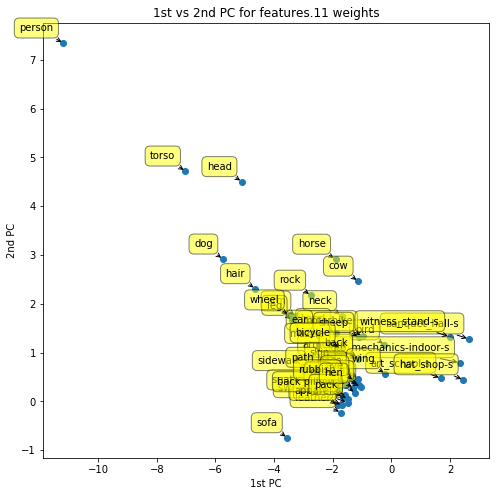

In [85]:
f, ax = plt.subplots(1,1, figsize=(8,8))

ax.scatter(
    pca_results[indices[label_i],0], pca_results[indices[label_i], 1], marker='o',
    cmap=plt.get_cmap('Spectral'))

for label, x, y in zip(label_names[indices[label_i]], pca_results[indices[label_i],0], pca_results[indices[label_i],1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-10, 10),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

ax.set_xlabel('1st PC')
ax.set_ylabel('2nd PC')
ax.set_title('1st vs 2nd PC for %s weights' % blob)
plt.show()

/users/ruthfong/anaconda2/lib/python2.7/site-packages/torch/autograd/_functions/basic_ops.py:17: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return a.add(b)


Epoch 25:	Alpha: 1231.165405	TV: 7845.632812	Loss: 0.287058	Tot Loss: 0.377826
Epoch 50:	Alpha: 1050.672974	TV: 6535.230469	Loss: 0.192321	Tot Loss: 0.268180
Epoch 75:	Alpha: 1222.266968	TV: 5651.904785	Loss: 0.169449	Tot Loss: 0.238190
Epoch 100:	Alpha: 1353.576050	TV: 5346.291992	Loss: 0.156835	Tot Loss: 0.223834
Epoch 125:	Alpha: 1359.633423	TV: 5305.145508	Loss: 0.154613	Tot Loss: 0.221261
Epoch 150:	Alpha: 1364.277100	TV: 5274.722656	Loss: 0.153729	Tot Loss: 0.220119
Epoch 175:	Alpha: 1371.582153	TV: 5249.167969	Loss: 0.153078	Tot Loss: 0.219285
Epoch 200:	Alpha: 1379.530640	TV: 5227.074707	Loss: 0.152471	Tot Loss: 0.218537


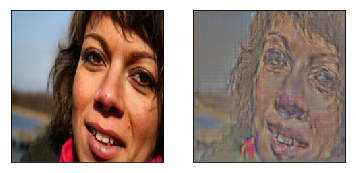

In [4]:
invert(image='../dataset/broden1_227/images/pascal/2008_004017.jpg', cuda=True)

memmap([[[ 14.04687977]],

        [[ 15.99878311]],

        [[ 11.70465851]],

        [[  9.11302567]],

        [[ 10.46727562]],

        [[ 16.51128006]],

        [[ 12.28488064]],

        [[ 14.9662981 ]],

        [[ 11.41852379]],

        [[ 14.91299438]],

        [[  6.45823479]],

        [[ 13.86669064]],

        [[ 12.11950207]],

        [[ 10.90765762]],

        [[ 14.32221508]],

        [[  9.36673355]],

        [[  8.37629509]],

        [[ 11.7553339 ]],

        [[ 15.74321747]],

        [[ 10.49804688]],

        [[ 12.8422451 ]],

        [[ 13.6769619 ]],

        [[ 17.90537262]],

        [[ 11.88316441]],

        [[ 11.61419487]],

        [[ 11.6637516 ]],

        [[  9.44749355]],

        [[ 11.86273956]],

        [[  9.14620876]],

        [[ 10.36045265]],

        [[ 12.72231674]],

        [[  9.76382732]],

        [[ 15.03854179]],

        [[ 13.26592445]],

        [[ 14.04807186]],

        [[ 11.7940073 ]],

        [[ 12.151577  ]],

 

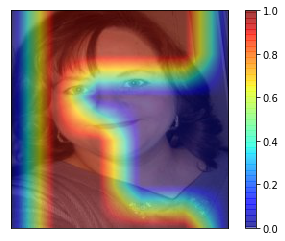

In [136]:
f, ax = plt.subplots(1,1)
ax.imshow(img)
cax = ax.imshow(imresize(upsample(input_var).data.cpu().numpy()[0][best_filter], size=img.shape[:2],
                         interp='bilinear', mode='F'), alpha=0.5, cmap='jet')
f.colorbar(cax)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [ ]:
input = torch.Tensor((blobdata[img_i] > thresh).astype(float)).unsqueeze(0)
input_var = Variable(input.cuda(), volatile=True) if cuda else Variable(input, volatile=True)

In [53]:
def activation_visualization_single(filter_i, img_i):
    img = im

(63305, 256, 6, 6)

In [61]:
np.where(blobdata > thresh)

(array([    0,     0,     0, ..., 63304, 63304, 63304]),
 array([  4,   4,   4, ..., 254, 254, 254]),
 array([1, 2, 4, ..., 0, 1, 1]),
 array([5, 5, 0, ..., 2, 1, 2]))

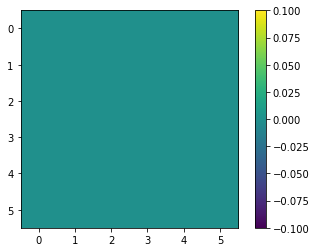

In [58]:
f, ax = plt.subplots(1,1)
img = imread(ds.filename(best_img))
mask = (blobdata[best_img][best_filter] > thresh[best_filter]).astype(float)
cax = ax.imshow(mask)
f.colorbar(cax)
plt.show()

In [40]:
sys.path.append('../../net_concepts/src')

In [41]:
from learn_concept_masks import *

In [42]:
label_cat = categories[np.where(labelcat[label_i])[0][0]]
print label_cat

object


In [43]:
fieldmap = blob_info.fieldmap

In [209]:
pf = loadseg.SegmentationPrefetcher(ds, categories=['texture'], once=True, batch_size=128, 
                                    ahead=4, thread=False)

In [210]:
batch = pf.fetch_batch()

In [213]:
x = [rec for rec in batch if rec['texture'] != []]

In [216]:
23x[0]['texture'])

list

In [45]:
perc_label = np.zeros(len(idx))

In [46]:
i = 0
for batch in pf.batches():
    for rec in batch:
        sw, sh = [rec[k] for k in ['sw', 'sh']]
        perc_label[i] = np.sum(rec[label_cat] == label_i) / float(sw * sh)
        i += 1

In [48]:
alpha = float(1.-np.mean(perc_label)) # need float typecast
print alpha

0.878479830454


In [49]:
def run_epoch(activations, label_cat, label_i, fieldmap, thresh, loader, model, criterion, optimizer, epoch, train=True, 
              cuda=False, iou_threshold=0.5):
    if train:
        model.train()
        volatile=False
    else:
        model.eval()
        volatile=True
    
    batch_size = loader.batch_size
    N = activations.shape[0]

    losses = AverageMeter()
    iou_intersects = AverageMeter()
    iou_unions = AverageMeter()
    
    i = 0
    for batch in loader.batches():
        start = time.time()
        if (i+1)*batch_size < N:
            idx = range(i*batch_size, (i+1)*batch_size)
        else:
            idx = range(i*batch_size, N)
        i += 1
        up = [upsample.upsampleL(fieldmap, act, shape=(113,113), reduction=2) for act in activations[idx]]  
        input = torch.Tensor((up > thresh).astype(float))
        input_var = (Variable(input.cuda(), volatile=volatile) if cuda
                    else Variable(input, volatile=volatile))
        target = torch.Tensor([np.squeeze((rec[label_cat] == label_i).astype(float)) for rec in batch])
        target_var = (Variable(target.cuda(), volatile=volatile) if cuda
                     else Variable(target, volatile=volatile))
        output_var = model(input_var)
        loss = criterion(output_var, target_var)
        losses.update(loss.data[0], input.size(0))
        iou_intersects.update(iou_intersect(output_var, target_var, iou_threshold).data.cpu().numpy())
        iou_unions.update(iou_union(output_var, target_var, iou_threshold).data.cpu().numpy())
        
        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        iou = np.true_divide(iou_intersects.sum, iou_unions.sum)[0]

        if train:
            print('Epoch {0}[{1}/{2}]\t'
                  'Avg Loss {losses.avg:.4f}\t'
                  'Overall IOU {3}\t'
                  'Time {4}\t'.format(epoch, i, int(round(N/batch_size)), iou, time.time()-start, losses=losses))
        else:
            print('Test [{0}/{1}]\t'
                  'Avg Loss {losses.avg:.4f}\t'
                  'Overall IOU {2}\t'
                  'Time {3}\t'.format(i, int(round(N/batch_size)), iou, time.time()-start, losses=losses))

    if train:
        print('Epoch {0}\t'
              'Avg Loss {losses.avg:.4f}\t'
              'Overall IOU {1}\t'
              'Time {2}\t'.format(epoch, iou, time.time()-start, losses=losses))
    else:
        print('Test\t'
              'Avg Loss {losses.avg:.4f}\t'
              'Overall IOU {0}\t'
              'Time {1}\t'.format(iou, time.time()-start, losses=losses))

    return (losses.avg, iou)

In [50]:
criterion = lambda x,y: BCELoss2d(x,y,alpha)
layer = CustomLayer(blob_info.shape[1], upsample=False, act=True, positive=False)
layer.cuda()

CustomLayer (
  (activation): Sigmoid ()
)

In [51]:
starting_lr = 1e-5
momentum = 0.9
nesterov = False
lower_bound = None

optimizer = Custom_SGD(layer.parameters(), starting_lr, momentum=momentum,
                      l1_weight_decay=0, l2_weight_decay=0, nesterov=nesterov,
                      lower_bound=lower_bound)

In [52]:
for i in range(30):
    pf = loadseg.SegmentationPrefetcher(ds, categories=categories, indexes=idx, once=True, batch_size=48, 
                                    ahead=4, thread=False)
    (_, iou) = run_epoch(blobdata[idx], label_cat, label_i, fieldmap, thresh, pf, layer, criterion, optimizer, i+1, 
                         train=True, cuda=True, iou_threshold=0.5)

Epoch 1[1/197]	Avg Loss -1397.2006	Overall IOU 0.090954169631	Time 8.15757894516	
Epoch 1[2/197]	Avg Loss -1378.0912	Overall IOU 0.0817742720246	Time 8.21285200119	
Epoch 1[3/197]	Avg Loss -1341.0852	Overall IOU 0.0822424590588	Time 8.22417998314	
Epoch 1[4/197]	Avg Loss -1362.4483	Overall IOU 0.091764755547	Time 8.14122200012	
Epoch 1[5/197]	Avg Loss -1383.4397	Overall IOU 0.0899257212877	Time 8.17720293999	
Epoch 1[6/197]	Avg Loss -1385.8980	Overall IOU 0.0913786813617	Time 8.30944991112	
Epoch 1[7/197]	Avg Loss -1379.5078	Overall IOU 0.0934709236026	Time 8.32680606842	
Epoch 1[8/197]	Avg Loss -1353.6184	Overall IOU 0.0906980037689	Time 9.2346367836	
Epoch 1[9/197]	Avg Loss -1352.5752	Overall IOU 0.0950002893806	Time 8.41037893295	
Epoch 1[10/197]	Avg Loss -1347.1197	Overall IOU 0.0945718958974	Time 8.92816305161	
Epoch 1[11/197]	Avg Loss -1363.4478	Overall IOU 0.0981348156929	Time 8.12424492836	
Epoch 1[12/197]	Avg Loss -1358.9353	Overall IOU 0.0970431268215	Time 8.07023596764	
Epoc

KeyboardInterrupt: 

In [78]:
object_segs = [img['object'] for img in ds.image if len(img['object']) > 0]

In [60]:
pf = loadseg.SegmentationPrefetcher(ds, categories=[label_cat], split='val', indexes=idx, once=True, batch_size=48, 
                                ahead=4, thread=False)

In [63]:
len(pf.indexes)

2845

In [58]:
batch = pf.fetch_batch()

In [59]:
batch

[{'fn': u'/home/ruthfong/NetDissect/dataset/broden1_227/images/pascal/2009_004227.jpg',
  'i': 44,
  'object': array([[[12, 12, 12, ..., 12, 12, 12],
          [12, 12, 12, ..., 12, 12, 12],
          [12, 12, 12, ..., 12, 12, 12],
          ..., 
          [14, 14, 14, ..., 14, 14, 14],
          [14, 14, 14, ..., 14, 14, 14],
          [ 0,  0,  0, ...,  0,  0,  0]]], dtype=int16),
  'sh': 113,
  'sw': 113},
 {'fn': u'/home/ruthfong/NetDissect/dataset/broden1_227/images/pascal/2008_000204.jpg',
  'i': 51,
  'object': array([[[16, 16, 16, ..., 16, 16, 16],
          [16, 16, 16, ..., 16, 16, 16],
          [16, 16, 16, ..., 16, 16, 16],
          ..., 
          [52, 52, 52, ..., 52, 52, 52],
          [52, 52, 52, ..., 52, 52, 52],
          [52, 52, 52, ..., 52, 52, 52]]], dtype=int16),
  'sh': 113,
  'sw': 113},
 {'fn': u'/home/ruthfong/NetDissect/dataset/broden1_227/images/ade20k/ADE_train_00017934.jpg',
  'i': 56,
  'object': array([[[ 0,  0,  0, ...,  0,  0,  0],
          [ 0, 

In [82]:
dataset_dir = '/home/ruthfong/NetDissect/dataset/broden1_227/images'
seg_path = os.path.join(dataset_dir, object_segs[0][0])

In [71]:
from indexdata import load_image_to_label

In [83]:
weights = layer.weight.data.cpu().numpy()

In [84]:
weight_mmap = ed.open_mmap(blob=blob, part='label_i_%d_weights' % label_i, mode='w+', dtype=float, shape=weights.shape)

In [85]:
weight_mmap[:] = weights[:]
ed.finish_mmap(weight_mmap)

In [87]:
weight_mmap = ed.open_mmap(blob=blob, part='label_i_%d_weights' % label_i, mode='r')

In [90]:
np.array(weight_mmap)

array([ -3.68934881e+19,   9.73501265e-01,  -0.00000000e+00,
        -1.14430201e+00,   2.00000000e+00,  -1.10182035e+00,
        -3.68934881e+19,  -1.48505020e+00,   3.68934881e+19,
         1.52106559e+00,  -1.08420217e-19,  -1.26963007e+00,
        -1.08420217e-19,   1.46636283e+00,   1.08420217e-19,
        -1.21861231e+00,  -2.00000000e+00,  -1.37963653e+00,
         2.00000000e+00,   1.15191066e+00,   1.08420217e-19,
        -1.13857853e+00,   3.68934881e+19,   9.99566317e-01,
         1.08420217e-19,  -1.39639914e+00,  -0.00000000e+00,
        -1.31756771e+00,   0.00000000e+00,   1.21551323e+00,
         1.08420217e-19,  -1.00583649e+00,  -1.08420217e-19,
        -1.27421308e+00,  -0.00000000e+00,   1.59739411e+00,
         0.00000000e+00,  -1.36832309e+00,   0.00000000e+00,
        -1.28661191e+00,  -3.68934881e+19,   1.38106072e+00,
         2.00000000e+00,  -1.22277212e+00,  -3.68934881e+19,
         1.37986910e+00,   0.00000000e+00,  -1.42640877e+00,
         1.08420217e-19,

In [4]:
from torchvision import models

In [5]:
net = models.alexnet(pretrained=True)

In [6]:
net

AlexNet (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU (inplace)
    (2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU (inplace)
    (5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU (inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU (inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  )
  (classifier): Sequential (
    (0): Dropout (p = 0.5)
    (1): Linear (9216 -> 4096)
    (2): ReLU (inplace)
    (3): Dropout (p = 0.5)
    (4): Linear (4096 -> 4096)
    (5): ReLU (inplace)
    (6): Linear (4096 -> 1000)
  )
)

In [137]:
list(net.modules())

[AlexNet (
   (features): Sequential (
     (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
     (1): ReLU (inplace)
     (2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
     (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
     (4): ReLU (inplace)
     (5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
     (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (7): ReLU (inplace)
     (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (9): ReLU (inplace)
     (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (11): ReLU (inplace)
     (12): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
   )
   (classifier): Sequential (
     (0): Dropout (p = 0.5)
     (1): Linear (9216 -> 4096)
     (2): ReLU (inplace)
     (3): Dropout (p = 0.5)
     (4): Linear (4096 -> 4096)
     (5): ReLU (inplace)
     (6): Linear (4096 -> 1000)
   )
 ), S

In [136]:
for i, m in enumerate(net.children()):
    print i, m

0 Sequential (
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU (inplace)
  (2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU (inplace)
  (5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU (inplace)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU (inplace)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU (inplace)
  (12): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
)
1 Sequential (
  (0): Dropout (p = 0.5)
  (1): Linear (9216 -> 4096)
  (2): ReLU (inplace)
  (3): Dropout (p = 0.5)
  (4): Linear (4096 -> 4096)
  (5): ReLU (inplace)
  (6): Linear (4096 -> 1000)
)


In [98]:
net.features[0]

Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))

In [138]:
blob = 'features.2'

In [113]:
module_name, module_index = blob.split('.')
module_index = int(module_index)

In [143]:
def get_pytorch_module(net, blob):
    modules = blob.split('.')
    if len(modules) == 1:
        return net._modules(get(blob))
    else:
        curr_m = net
        for m in modules:
            curr_m = curr_m._modules.get(m)
        return curr_m

In [144]:
print get_module(net, 'features.2')

MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))


In [114]:
net._modules[module_name][module_index]

MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))

In [118]:
print net._modules.get('features')

Sequential (
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU (inplace)
  (2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU (inplace)
  (5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU (inplace)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU (inplace)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU (inplace)
  (12): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
)


In [119]:
z = np.zeros(10, dtype=bool)

In [120]:
z

array([False, False, False, False, False, False, False, False, False, False], dtype=bool)

In [145]:
net = models.__dict__['inception_v3'](pretrained=True)

In [146]:
net

Inception3 (
  (Conv2d_1a_3x3): BasicConv2d (
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True)
  )
  (Conv2d_2a_3x3): BasicConv2d (
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True)
  )
  (Conv2d_2b_3x3): BasicConv2d (
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True)
  )
  (Conv2d_3b_1x1): BasicConv2d (
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True)
  )
  (Conv2d_4a_3x3): BasicConv2d (
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True)
  )
  (Mixed_5b): InceptionA (
    (branch1x1): BasicConv2d (
      (conv): Conv2d(192, 64, kernel_

In [147]:
print get_module(net, 'Mixed_5c.branch_pool.conv')

Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
